In [26]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Kraus
import numpy as np
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import transpile
from qiskit_aer.noise import QuantumError
from qiskit.circuit.library import XGate, ZGate
from random import randint

In [27]:
# number of qubits
n = 9
p = 0.2

error_list = []

# Identity operation on 9 qubits
id_circ = QuantumCircuit(n)
error_list.append(((id_circ, list(range(n))), 1 - p))

# X or Z on exactly one qubit
for q in range(n):
    x_circ = QuantumCircuit(n)
    x_circ.x(q)
    error_list.append(((x_circ, list(range(n))), p/(2*n)))

    z_circ = QuantumCircuit(n)
    z_circ.z(q)
    error_list.append(((z_circ, list(range(n))), p/(2*n)))

# Build the correlated error channel
random_single_qubit_error = QuantumError(error_list)

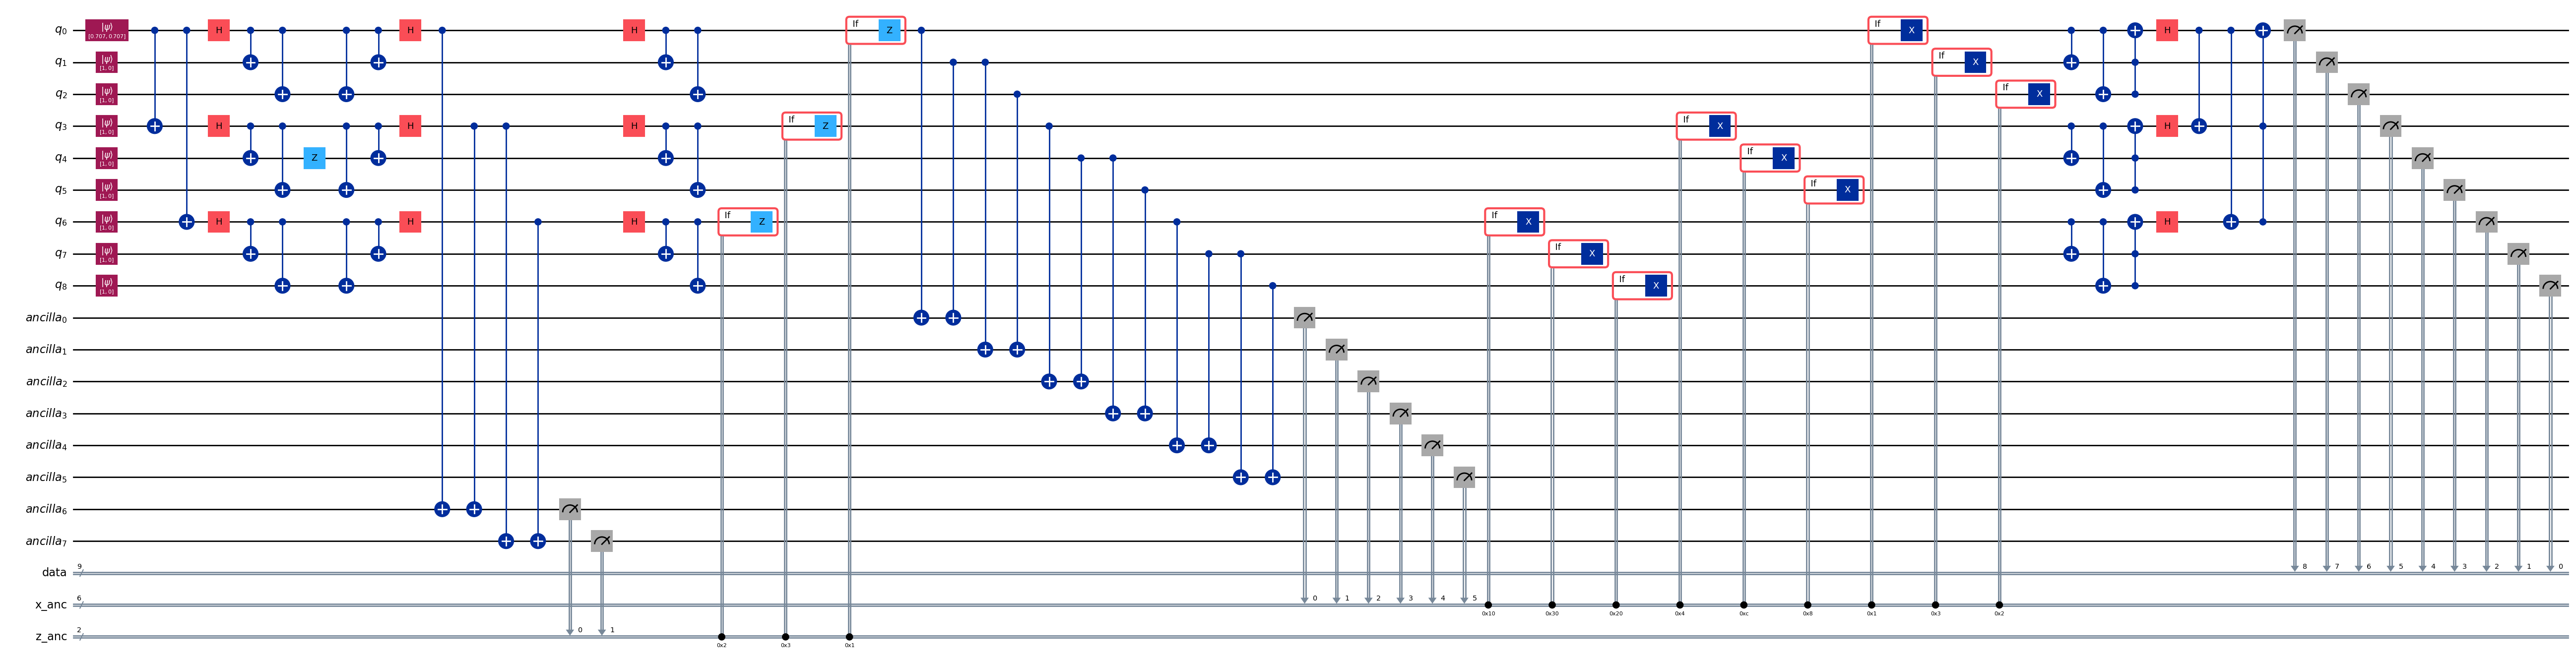

In [31]:
qreg = QuantumRegister(9, 'q')
qreg2 = QuantumRegister(8, 'ancilla')
creg1 = ClassicalRegister(9, 'data')
creg2 = ClassicalRegister(6, 'x_anc')
creg3 = ClassicalRegister(2, 'z_anc')
qc=QuantumCircuit(qreg, qreg2,creg1,creg2, creg3)

qc.initialize([1/np.sqrt(2), 1/np.sqrt(2)], 0) #prepare state in superposition
for i in range(1, 9):
    qc.initialize([1, 0], i)
qc.cx(0,3)
qc.cx(0,6)
qc.h([0,3,6])
for i in [0,3,6]:
    qc.cx(i, i+1)
    qc.cx(i, i+2)

qc.barrier(range(15))

####### applying random error
if randint(0,1):
    if randint(0,1):
        qc.x(randint(0,8))
    else:
        qc.z(randint(0,8))
    
qc.barrier(range(15))

####### phase-flip correction

for i in [0,3,6]:
    qc.cx(i, i+2)
    qc.cx(i, i+1)
qc.h([0,3,6])
qc.cx(0, 15)
qc.cx(3, 15)
qc.cx(3, 16)
qc.cx(6, 16)

qc.barrier(range(17))

for i in range(2):
    qc.measure(i+15, creg3[i])



qc.barrier(range(17))

qc.h([0,3,6])
for i in [0,3,6]:
    qc.cx(i, i+1)
    qc.cx(i, i+2)
qc.barrier(range(15))


with qc.if_test((creg3, 0b10)):
    qc.z(6)
with qc.if_test((creg3, 0b11)):
    qc.z(3)
with qc.if_test((creg3, 0b01)):
    qc.z(0)


qc.barrier(range(15))

######



###### bit flip correction
qc.cx(0, 9)
qc.cx(1, 9)
qc.cx(1, 10)
qc.cx(2, 10)

qc.barrier(range(15))

qc.cx(3, 11)
qc.cx(4, 11)
qc.cx(4, 12)
qc.cx(5, 12)

qc.barrier(range(15))

qc.cx(6, 13)
qc.cx(7, 13)
qc.cx(7, 14)
qc.cx(8, 14)

qc.barrier(range(15))

for i in range(6):
    qc.measure(i+9, creg2[i])




with qc.if_test((creg2, 0b010000)):
    qc.x(6)
with qc.if_test((creg2, 0b110000)):
    qc.x(7)
with qc.if_test((creg2, 0b100000)):
    qc.x(8)
with qc.if_test((creg2, 0b000100)):
    qc.x(3)
with qc.if_test((creg2, 0b001100)):
    qc.x(4)
with qc.if_test((creg2, 0b001000)):
    qc.x(5)
with qc.if_test((creg2, 0b000001)):
    qc.x(0)
with qc.if_test((creg2, 0b000011)):
    qc.x(1)
with qc.if_test((creg2, 0b000010)):
    qc.x(2)

######

qc.barrier(range(15))


for i in [0,3,6]:
    qc.cx(i, i+1)
    qc.cx(i, i+2)
    qc.ccx(i+1,i+2,i)
    qc.h(i)

qc.barrier(range(15))

qc.cx(0,3)
qc.cx(0,6)
qc.ccx(3,6,0)

qc.barrier(range(15))
qc.measure([0,1,2,3,4,5,6,7,8], [8,7,6,5,4,3,2,1,0])

qc.draw("mpl", fold=-1, plot_barriers=False)


In [32]:
simulator = AerSimulator(method="automatic")
tqc = transpile(qc, simulator)
result = simulator.run(tqc, shots=10).result()

{'000000000': 2, '100000000': 8}


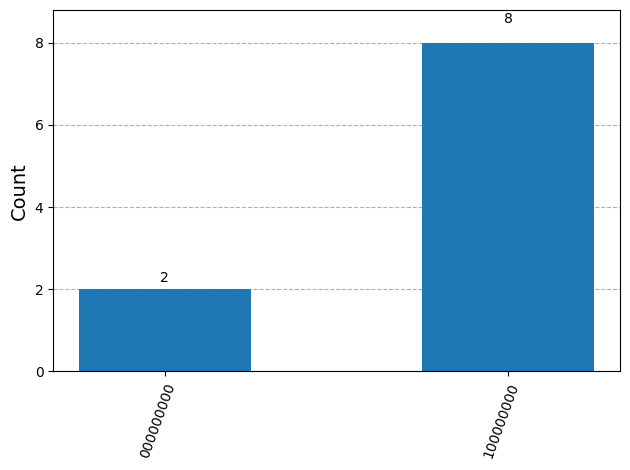

In [33]:
from qiskit.result import marginal_counts
counts = result.get_counts(tqc)

data_counts = marginal_counts(counts, indices=range(0,9))

print(data_counts)
plot_histogram(data_counts)